# Image Stitching with RANSAC and SIFT

This notebook demonstrates how to stitch two images together using SIFT features and RANSAC.

In [1]:
%matplotlib widget

import math

import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from matplotlib.patches import ConnectionPatch
from skimage.feature import SIFT, match_descriptors
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize, ProjectiveTransform, SimilarityTransform, warp
from skimage import measure

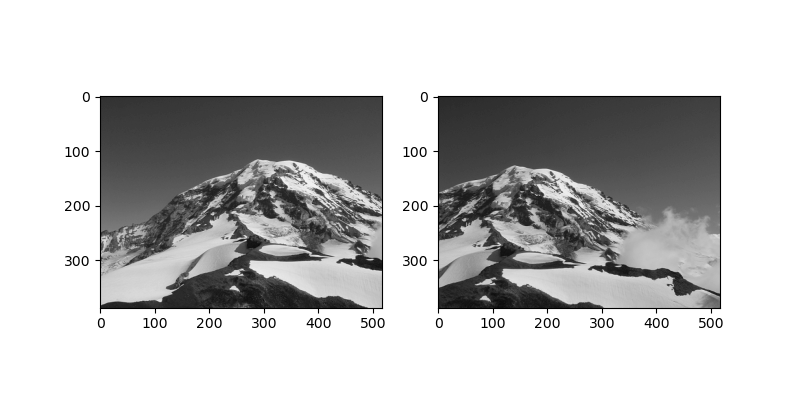

In [2]:
dst_img_rgb = np.asarray(Image.open('img/Rainier1.png'))
src_img_rgb = np.asarray(Image.open('img/Rainier2.png'))

if dst_img_rgb.shape[2] == 4:
    dst_img_rgb = rgba2rgb(dst_img_rgb)
if src_img_rgb.shape[2] == 4:
    src_img_rgb = rgba2rgb(src_img_rgb)

dst_img = rgb2gray(dst_img_rgb)
src_img = rgb2gray(src_img_rgb)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img, cmap='gray')
ax2.imshow(src_img, cmap='gray')

## Step 1. Compute SIFT descriptors and keypoints for each input image

In [3]:
detector1 = SIFT()
detector2 = SIFT()
detector1.detect_and_extract(dst_img)
detector2.detect_and_extract(src_img)
keypoints1 = detector1.keypoints
descriptors1 = detector1.descriptors
keypoints2 = detector2.keypoints
descriptors2 = detector2.descriptors

In [4]:
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)
print(matches.shape)

(618, 2)


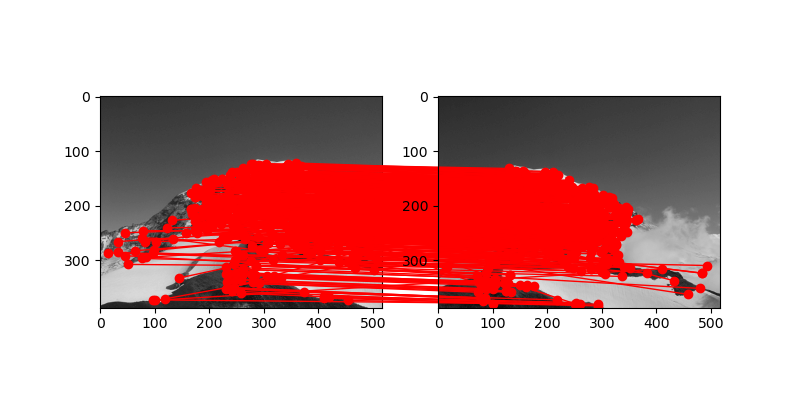

In [5]:
# Select the points in img1 that match with img2 and vice versa
dst = keypoints1[matches[:, 0]]
src = keypoints2[matches[:, 1]]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img, cmap='gray')
ax2.imshow(src_img, cmap='gray')

for i in range(src.shape[0]):
    coordB = [dst[i, 1], dst[i, 0]]
    coordA = [src[i, 1], src[i, 0]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst[i, 1], dst[i, 0], 'ro')
    ax2.plot(src[i, 1], src[i, 0], 'ro')

In [6]:
sk_M, sk_best = measure.ransac((src[:, ::-1], dst[:, ::-1]), ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=300)
print(sk_M)

<ProjectiveTransform(matrix=
    [[ 7.97292430e-01,  3.98490467e-02,  1.56030360e+02],
     [-1.09527369e-01,  9.33328225e-01,  6.46609425e+00],
     [-4.11304684e-04,  2.58783431e-05,  1.00000000e+00]])>


466


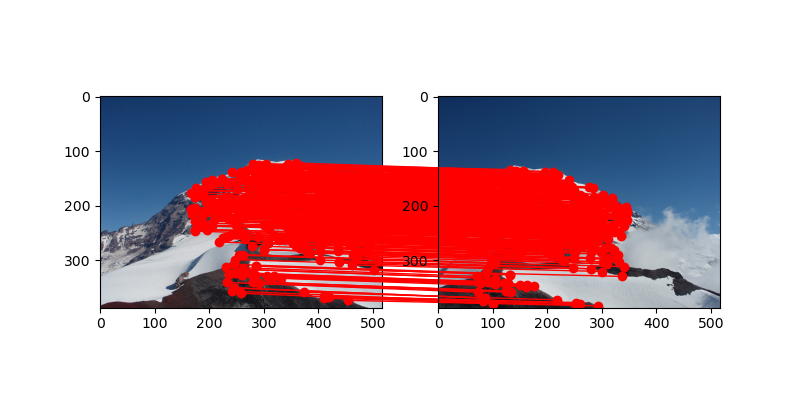

In [7]:
print(np.count_nonzero(sk_best))
src_best = keypoints2[matches[sk_best, 1]][:, ::-1]
dst_best = keypoints1[matches[sk_best, 0]][:, ::-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img_rgb)
ax2.imshow(src_img_rgb)

for i in range(src_best.shape[0]):
    coordB = [dst_best[i, 0], dst_best[i, 1]]
    coordA = [src_best[i, 0], src_best[i, 1]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst_best[i, 0], dst_best[i, 1], 'ro')
    ax2.plot(src_best[i, 0], src_best[i, 1], 'ro')

# Compute the output shape

[455 732]


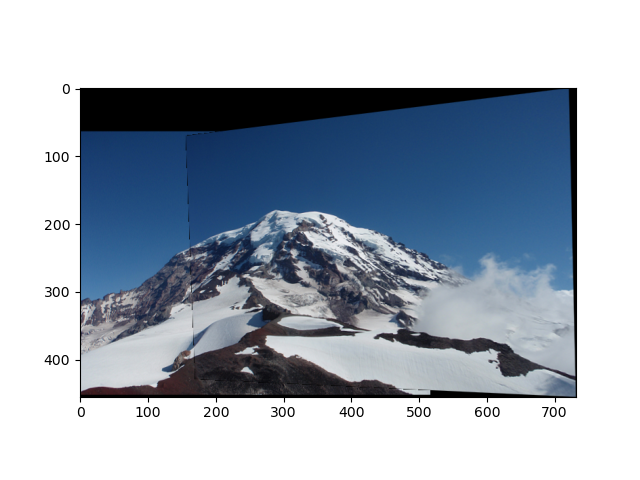

In [11]:
# Transform the corners of img1 by the inverse of the best fit model
rows, cols = dst_img.shape
corners = np.array([
    [0, 0],
    [cols, 0],
    [0, rows],
    [cols, rows]
])

corners_proj = sk_M(corners)
all_corners = np.vstack((corners_proj[:, :2], corners[:, :2]))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1]).astype(int)
print(output_shape)

offset = SimilarityTransform(translation=-corner_min)
dst_warped = warp(dst_img_rgb, offset.inverse, output_shape=output_shape)

tf_img = warp(src_img_rgb, (sk_M + offset).inverse, output_shape=output_shape)

# Combine the images
foreground_pixels = tf_img[tf_img > 0]
dst_warped[tf_img > 0] = tf_img[tf_img > 0]

# Plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(dst_warped)